## STMO Project

In [8]:
!pip install osmnx networkx

In [9]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

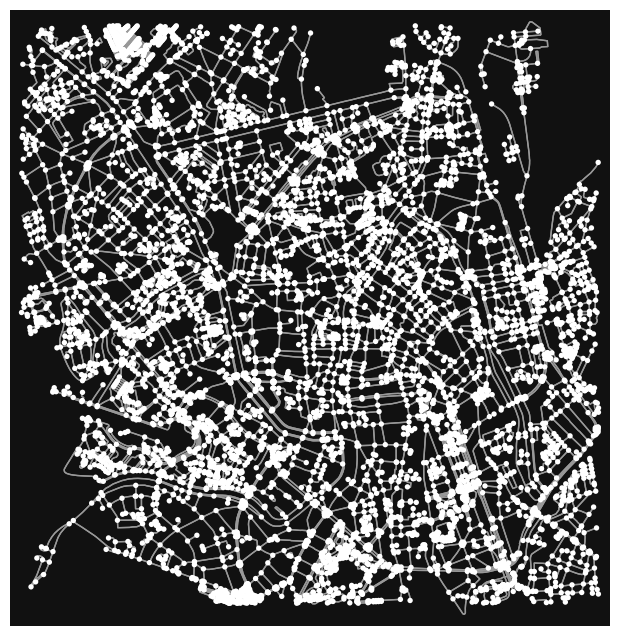

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
# Define the center of Ghent (latitude and longitude) and a buffer distance in meters
center_point = (51.054342, 3.717424)  # Latitude and longitude for Ghent center
buffer_distance = 2000  # 2000 meters (2 km radius)

# Download the street network data within the buffer distance around the center point
graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')

# Plot the graph to verify
ox.plot_graph(graph)

In [24]:
def simulated_annealing(graph, start_node, distance, max_iterations=1000, initial_temp=1000, cooling_rate=0.003):
    """
    Perform simulated annealing to find an approximate route of a given distance in a graph.

    Parameters:
    - graph: A network graph object (from OSMnx).
    - start_node: The starting node in the graph.
    - distance: Desired approximate distance for the route (in meters).
    - max_iterations: Maximum number of iterations (default=1000).
    - initial_temp: Starting temperature for the annealing process (default=1000).
    - cooling_rate: Cooling rate for the temperature (default=0.003).

    Returns:
    - best_route: The best route found.
    - best_length: The length of the best route.
    """
    def calculate_route_length(route):
        """Calculate the total length of a route."""
        length = 0
        for u, v in zip(route[:-1], route[1:]):
            # Extract edge data for this edge (u, v)
            edge_data = graph.get_edge_data(u, v, default={})
            # Some edges may have multiple attributes; handle accordingly
            if isinstance(edge_data, dict):
                length += edge_data.get('length', 0)
            elif isinstance(edge_data, list):
                length += min(e.get('length', float('inf')) for e in edge_data)
        return length

    def get_random_neighbor(route):
        """
        Generate a random neighbor by modifying the route.
        Ensures the neighbor is valid for the graph.
        """
        new_route = route[:]
        if len(route) > 2:
            idx1, idx2 = random.sample(range(1, len(route) - 1), 2)  # Avoid swapping start/end nodes
            new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
        return new_route

    # Validate the start node
    if start_node not in graph:
        raise ValueError(f"Start node {start_node} is not in the graph.")

    # Initialize the route with a simple circular path
    target_node = random.choice(list(graph.nodes))
    while not nx.has_path(graph, start_node, target_node):
        target_node = random.choice(list(graph.nodes))
    current_route = nx.shortest_path(graph, start_node, target_node, weight='length')
    current_route += nx.shortest_path(graph, current_route[-1], start_node, weight='length')[1:]
    current_length = calculate_route_length(current_route)

    best_route = current_route
    best_length = current_length
    temperature = initial_temp

    for i in range(max_iterations):
        # Generate a neighbor route
        new_route = get_random_neighbor(current_route)
        try:
            new_length = calculate_route_length(new_route)
        except Exception:
            continue  # Skip invalid routes

        delta_length = new_length - current_length

        # Acceptance condition
        if delta_length < 0 or np.exp(-delta_length / temperature) > random.random():
            current_route = new_route
            current_length = new_length

            # Update the best route if the new one is closer to the desired distance
            if abs(current_length - distance) < abs(best_length - distance):
                best_route = current_route
                best_length = current_length

        # Cool down the temperature
        temperature *= (1 - cooling_rate)

    return best_route, best_length

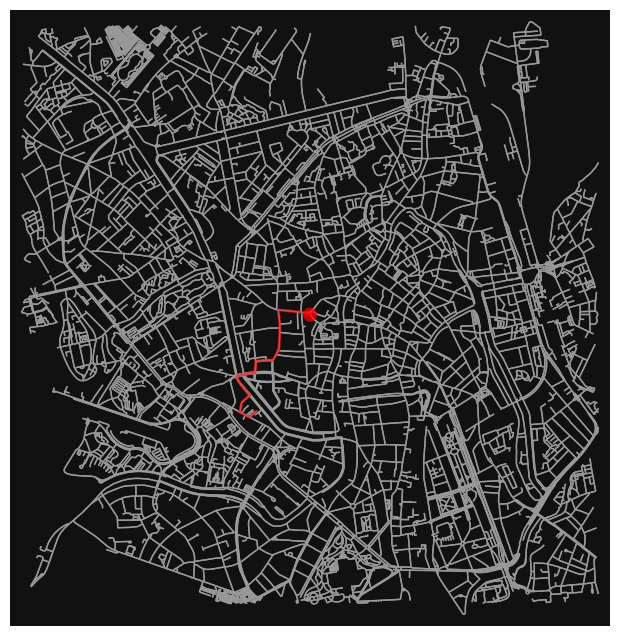

In [25]:
# Define the start point (latitude, longitude) and desired distance in meters
start_point = (51.0543, 3.7174)  # Example coordinates in Ghent
distance = 5000  # 5 kilometers

# Get the nearest network node to the start point
start_node = ox.distance.nearest_nodes(graph, X=start_point[1], Y=start_point[0])

# Run the simulated annealing algorithm
best_route, best_length = simulated_annealing(graph, start_node, distance)

# Plot the optimized route
fig, ax = ox.plot_graph_route(graph, best_route, route_linewidth=2, node_size=0)
plt.show()